In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader
from torchvision import datasets

In [ ]:
device = "cuda" #if torch.cuda.is_available() else "cpu"
dtype = torch.float32

**Supervised**

قسمت آ

In [ ]:
torch.manual_seed(99)

In [ ]:
transform = Compose([ToTensor(),
                     Lambda(lambda x: torch.flatten(x))])

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=10000)
train_acc_dataloader = DataLoader(training_data, batch_size=50000) # This is for checking accuracy on training set.

قسمت ب

In [ ]:
def overlay_y_on_x(x, y):
    z = x.clone() / x.max()
    z[:, :10] *= 0.0
    z[range(x.shape[0]), y] = torch.tensor([1], dtype = torch.float)
    return z

قسمت ج

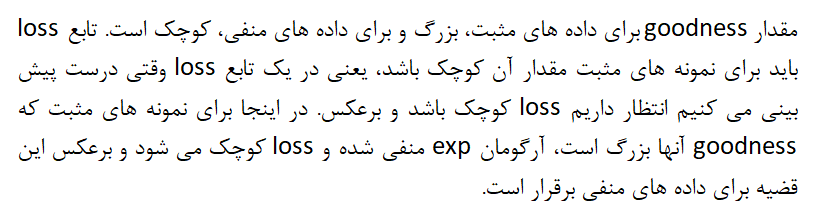

In [ ]:
class LearningNet(nn.Module):

    def __init__(self, dims):
        super().__init__()
        self.layers = []
        self.l1 = LinearLayer(dims[0], dims[1], device = device)

    def predict(self, x, y):
        goodness_per_label = []
        for label in range(10):
            data = overlay_y_on_x(x, label)
            goodness = []
            out1 = self.l1(data)
            goodness.extend([torch.mean(out1**2, dim=1)])
            goodness_per_label.extend([sum(goodness).unsqueeze(1)])
            predictions = torch.cat(goodness_per_label, 1).argmax(1)
        return (predictions == y).float().mean().item()

    def perform(self, x_pos, x_neg):
        data_pos1, data_neg1 = self.l1.train(x_pos, x_neg)



In [ ]:
class LinearLayer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=device, dtype=dtype):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.029)
        self.threshold = 2


    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-5)
        return self.relu(x_direction @ self.weight.T + self.bias)

    def train(self, x_pos, x_neg):
        g_pos = torch.mean(self.forward(x_pos)**2, dim = 1) # Calculating goodness
        g_neg = torch.mean(self.forward(x_neg)**2, dim = 1) # Calculating goodness
        loss = torch.mean(torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold]))))
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

قسمت د

In [ ]:
epochs = 20
lrnet = LearningNet([784, 600])
for e in range(epochs):
    for t, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)
        x_pos = overlay_y_on_x(x, y)
        rnd = torch.randperm(x.shape[0])
        x_neg = overlay_y_on_x(x, y[rnd])
        lrnet.perform(x_pos, x_neg)

x_train_acc, y_train_acc = next(iter(train_acc_dataloader))

train_accuracy = lrnet.predict(x_train_acc.to(device), y_train_acc.to(device))
print('Train Accuracy:', train_accuracy)
print('Train Error: ', 1-train_accuracy)

x_test, y_test = next(iter(test_dataloader))
x_test, y_test = x_test.to(device), y_test.to(device)
test_accuracy = lrnet.predict(x_test, y_test)
print('---------------------------')
print('Test Accuracy:', test_accuracy)
print(f'Test Error: ', 1-test_accuracy)

Train Accuracy: 0.973360002040863
Train Error:  0.026639997959136963
---------------------------
Test Accuracy: 0.9672999978065491
Test Error:  0.03270000219345093


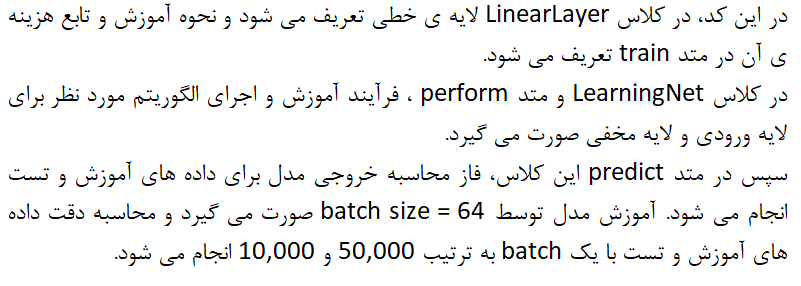

در این تمرین از ویدیوی زیر الهام گرفته شده است.

https://www.youtube.com/watch?v=kvdOow3__CI